# Feature Selection and Engineering

##### *In which we boost, combine, split, or otherwise manipulate the features of crabs.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/2-features)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/2-features/features.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


### Define Constants


In [23]:
%%time
CACHE_FILE = '../cache/splitcrabs.feather'
NEXT_CACHE_FILE = '../cache/designrcrabs.feather'
NEXT_NOTEBOOK = '../3-evaluation/evaluation.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/designr_model.weights.h5'
MODEL_DOT_FILE = '../cache/dot_diagram.png'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries


In [24]:
%%time
from notebooks.time_for_crab.mlutils import display_df, generate_neural_pyramid
from notebooks.time_for_crab.mlutils import plot_training_loss, plot_training_loss_from_dict, plot_true_vs_pred_from_dict
from notebooks.time_for_crab.mlutils import score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task
elif keras_backend == 'jax':
    import jax
    print(f'JAX version: {jax.__version__}')
    print(f'JAX devices: {jax.devices()}')
else:
    print('Unknown backend; Proceed with caution.')

import numpy as np
import pandas as pd

from typing import Generator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 0 ns
Wall time: 0 ns


### Load Data from Cache

In the [previous section](../1-models/models.ipynb), we saved the normalized training data to the cache.


In [25]:
%%time
crabs = pd.read_feather(CACHE_FILE)
crabs_test = pd.read_feather(CACHE_FILE.replace('.feather', '_test.feather'))

display_df(crabs, show_distinct=True)

# split features from target
X_train = crabs.drop([PREDICTION_TARGET], axis=1)
y_train = crabs[PREDICTION_TARGET]

X_test = crabs_test.drop([PREDICTION_TARGET], axis=1)
y_test = crabs_test[PREDICTION_TARGET]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')


DataFrame shape: (3031, 11)
First 5 rows:
        Length  Diameter    Height    Weight  Shucked Weight  Viscera Weight  \
3483  1.724609  1.312500  0.500000  50.53125       25.984375        9.429688   
993   1.612305  1.312500  0.500000  41.09375       17.031250        7.273438   
1427  1.650391  1.262695  0.475098  40.78125       19.203125        8.078125   
3829  1.362305  1.150391  0.399902  25.43750        9.664062        4.691406   
1468  1.250000  0.924805  0.375000  30.09375       14.007812        6.320312   

      Shell Weight  Sex_F  Sex_I  Sex_M  Age  
3483     13.070312  False  False   True   12  
993      14.320312   True  False  False   13  
1427      5.046875  False  False   True   11  
3829      9.781250  False  False   True   10  
1468      8.390625  False  False   True    9  
<class 'pandas.core.frame.DataFrame'>
Index: 3031 entries, 3483 to 658
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 

## Rebuild our Model

### Neural Network Architecture

We'll use a simple feedforward neural network with one hidden layer.

- **Input Layer**
    - All features, for now.
- **Normalizer Layer**
    - Adapted to all features in the training data. 
- **Hidden Layers**
    - 1 dense layers each with 8 units and ReLU activation.
- **Output Layer**
    - Layer with one output, the predicted age.


In [26]:
%%time
# layer: input - all features (for now)
layer_feature_input = keras.layers.Input(shape=(len(X_train.columns),))

# layer: normalizer
layer_feature_normalizer = keras.layers.Normalization(axis=-1)
layer_feature_normalizer.adapt(np.array(X_train))

# layer(s): hidden (relu) - 8
num_hidden_layers = 1
num_units = 8
layer_8_hidden_relu_list = generate_neural_pyramid(num_hidden_layers, num_units)

# layer: output (linear regression)
layer_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
# initialize the all_models dictionary
all_models = {'full_feature_model': keras.Sequential([
        layer_feature_input,
        layer_feature_normalizer,
        *layer_8_hidden_relu_list,
        layer_8_output])}

all_models['full_feature_model'].summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (476.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 23 ms


### Configure the Neural Network Model

- **Optimizer**
    - Nadam: Adaptive Moment Estimation with Nesterov Accelerated Gradient
        - Combines Adam and Nesterov momentum.
        - Adam is a popular optimizer for its speed and performance.
        - Nesterov momentum helps the optimizer converge faster.
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint
    - Learning Rate Scheduler
        - Start = 0.01 (best from static tuning)
        - Factor = 0.75 (reduce learning rate by 25%)
        - Patience = 9 epochs (wait 9 epochs of non-improvement before reducing learning rate)


In [27]:
%%time
learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75,
    patience=9,
    verbose=1)

full_feature_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_full_feature.weights.h5'),
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1)

all_models['full_feature_model'].compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.01),
    loss='mean_squared_error')


CPU times: total: 0 ns
Wall time: 2.52 ms


#### Show Distributions of Features

If you recall from [exploratory data analysis](../0-exploratory/exploratory.ipynb), the features are normalized using the training data's ranges as part of the model's architecture.

Let's take another look at the original distributions of the features.


CPU times: total: 93.8 ms
Wall time: 184 ms


Text(0.5, 1.0, 'Feature Distributions')

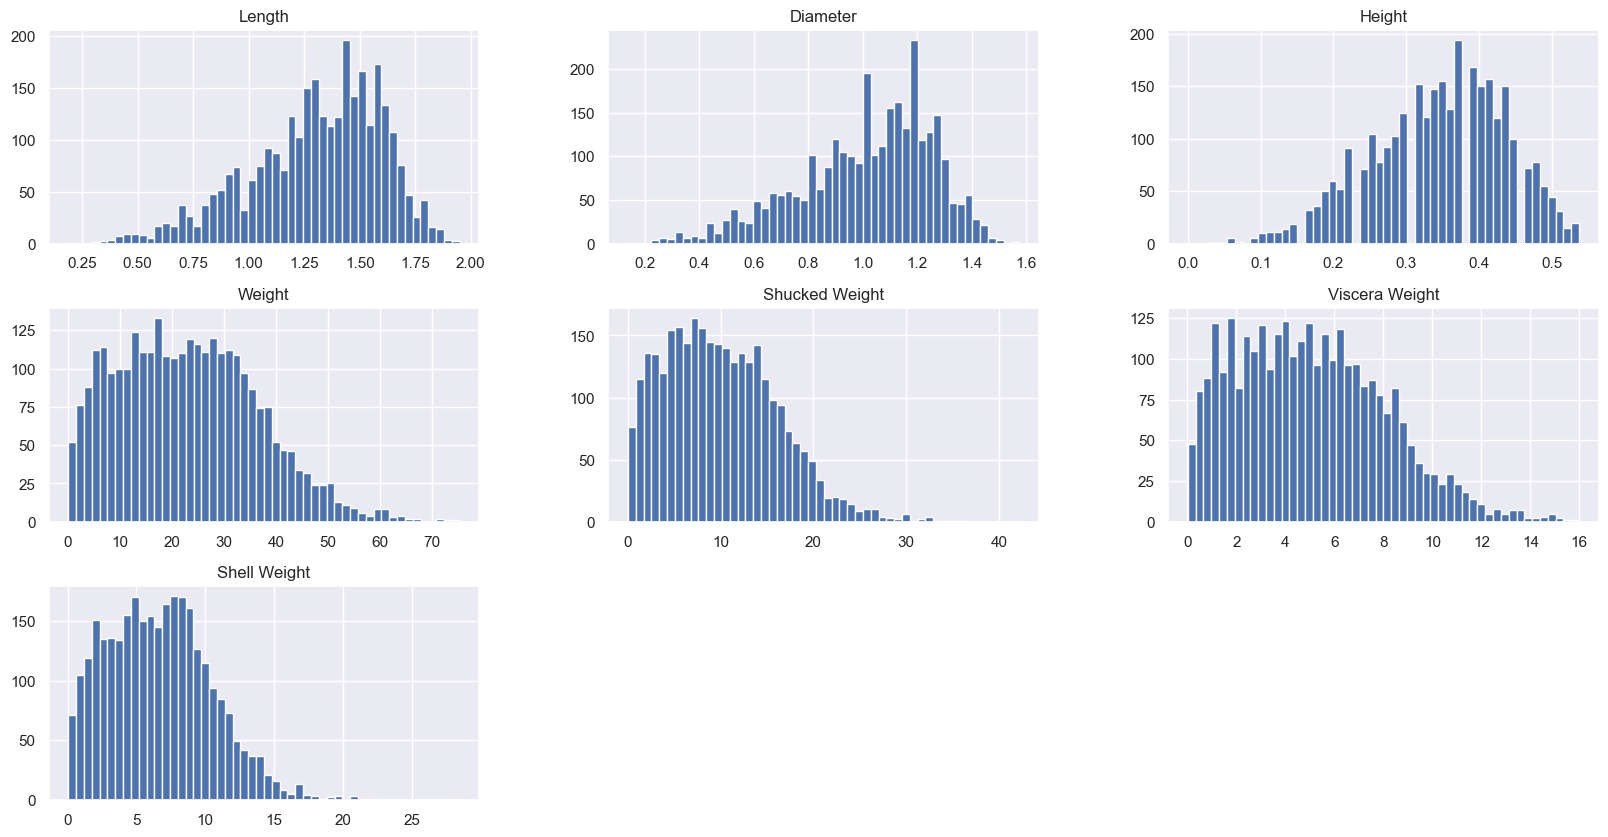

In [28]:
%%time
# Plotting the distribution of the features
X_train.hist(figsize=(20, 10), bins=50)
plt.title('Feature Distributions')


### Show Correlation Matrix

To see how the features are correlated with each other.


CPU times: total: 125 ms
Wall time: 245 ms


<Axes: title={'center': 'Correlation Graph'}>

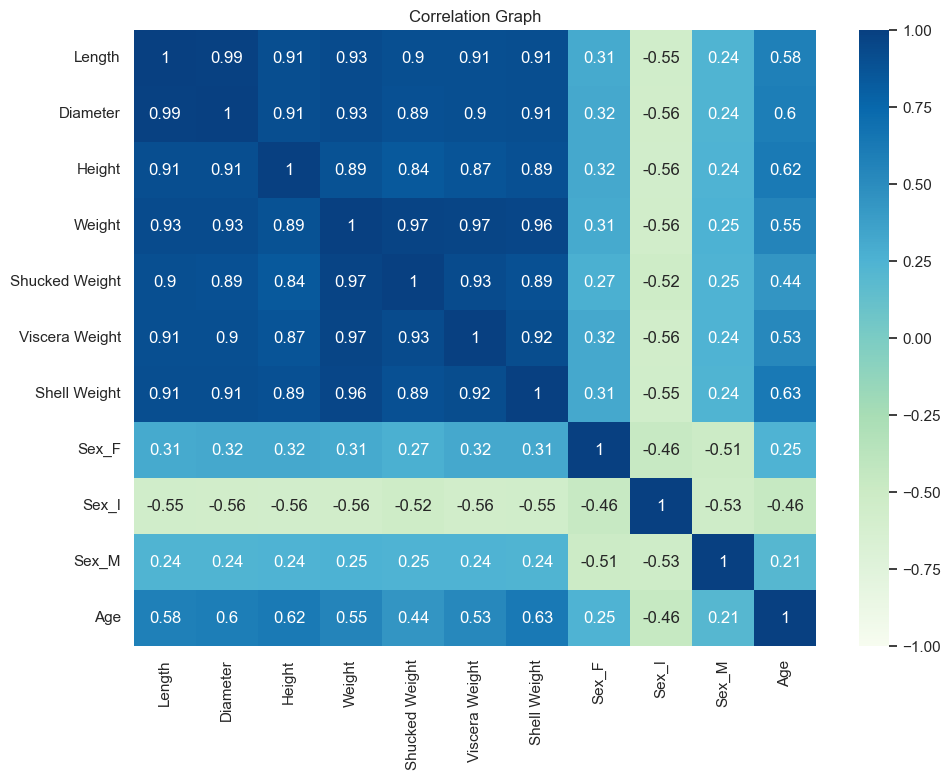

In [29]:
%%time
plt.figure(figsize = (11,8))
plt.title('Correlation Graph')
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.set()
sns.heatmap(crabs.corr(), vmin=-1, vmax=1, annot=True, cmap='GnBu')


### Feature Significance

Remove features with low significance.


In [30]:
%%time
# use VarianceThreshold?


CPU times: total: 0 ns
Wall time: 0 ns


### Data Augmentation

Crabs are complex creatures. Let's engineer some features to help our model find the best crabs for harvest.

We'll need to use domain knowledge to extract more features from our dataset's column.

![This kills the crab.](https://i.kym-cdn.com/photos/images/newsfeed/000/112/843/killcrab.jpg)

For example, we can find the edible weight of the crab by subtracting the viscera weight from the shucked weight.  
However, we need to be careful not to overfit the model by adding coliinear features.


In [31]:
%%time
def data_augmentation(df:pd.DataFrame) -> pd.DataFrame:
    """Add new features to the DataFrame.

    Driven by domain knowledge.

    :param df: The data.
    :return: The data with new features.
    """
    # add new features by combining existing features
    df['Edible Weight'] = df['Shucked Weight'] - df['Viscera Weight']
    return df


CPU times: total: 0 ns
Wall time: 0 ns


## Feature Selection

Selecting only the most important features. We'll use **Recursive Feature Elimination** (RFE).


In [32]:
%%time
# implement RFE from scratch

def rfe(X:pd.DataFrame, y:pd.Series, n_features:int) -> pd.DataFrame:
    """Select the most important features using Recursive Feature Elimination.

    :param X: The features.
    :param y: The target.
    :param n_features: The number of features to select.
    :return: The selected features.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.feature_selection import RFE

    # create the RFE model and select n features
    model = LinearRegression()
    rfe = RFE(model, n_features)
    fit = rfe.fit(X, y)

    # get the selected features
    selected = fit.support_
    return X.loc[:, selected]


CPU times: total: 0 ns
Wall time: 0 ns


## Save the Data

So we can pick this back up on the [next step](../3-evaluation/evaluation.ipynb).


In [33]:
%%time
# save the training and test data separately
pd.concat([X_train, y_train], axis=1, join='outer').to_feather(NEXT_CACHE_FILE)
pd.concat([X_test, y_test], axis=1, join='outer').to_feather(NEXT_CACHE_FILE.replace('.feather', '_test.feather'))


CPU times: total: 0 ns
Wall time: 5.01 ms


## Onwards to Final Evaluation

See the [next section](../3-evaluation/evaluation.ipynb) for the final evaluation.

[`<html link>`](https://nbviewer.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/3-evaluation/evaluation.ipynb) for model evaluation.
